# **Customer Segmentation using Unsupervised Machine Learning**

# **Importing the Required packages**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import nltk
nltk.download('punkt')
import wordcloud
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#uploading the dataset
from google.colab import files
data = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


# **Investigating the Data**

In [ ]:
#Loading the data
data = pd.read_excel('Online Retail.xlsx', dtype={'StockCode':str})
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
data.shape

(541909, 8)

In [ ]:
# Checking for null values.
check = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
check = check.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
check

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,1454.000000,0.0,0.0,0.0,135080.000000,0.0
% Null values,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


This says that around 13000 data points don't have a customer id, which is approximately 25% of the data. So, I'm going to remove that 25% of the data. 

In [ ]:
# Removing null values
data.dropna(axis=0, subset = ['CustomerID'], inplace=True)
check = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
check = check.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
check

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now there are no null values! After removing the 25% of null values data where the customer ID was not present, seems like the "Description" data which had approx. 1400 null values is also free from null values.

In [ ]:
# Checking for Duplicates :
data.duplicated().sum()

5225

In [ ]:
# Removing duplicate entries :
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

# **Exploratory Data Analysis**

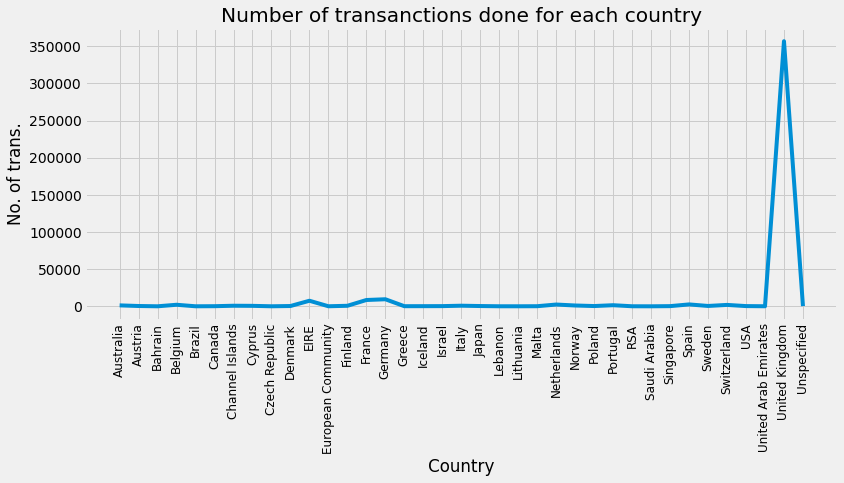

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data.groupby(['Country'])['CustomerID'].count())
plt.xticks(rotation = 90, fontsize = 12)
plt.title("Number of transanctions done for each country")
plt.ylabel("No. of trans.")
plt.xlabel("Country")
plt.show()

In [ ]:
info = pd.DataFrame(data = data.groupby(['Country'])['InvoiceNo'].nunique(), index=data.groupby(['Country']).groups.keys()).T
info

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Lebanon,Lithuania,Malta,Netherlands,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,69,19,2,119,1,6,33,20,5,21,319,5,48,458,603,6,7,6,55,28,1,4,10,101,40,24,70,1,2,10,105,46,71,7,3,19857,8


I plotted Number of Transactions vs Country. It is clear from the plot that UK has the highest number of transactions. Next, I have grouped the information of unique invoice numbers and the corresponding countries, which would give me the exact number of transactions. So, it says that the number of transactions in UK were 19857. There were transactions as low as 1 in few countries like Brazil,Lebanon, RSA etc.

In [ ]:
# To see how many different products were sold in the year data was collected.
print(len(data['StockCode'].value_counts()))

3684


In [ ]:
#To see how many different transanctions were done.
print(len(data['InvoiceNo'].value_counts()))

22190


In [ ]:
# To see how many different Customers are there.
print(len(data['CustomerID'].value_counts()))

4372


In [ ]:
#Making a dataframe of products, transactions and number of customers
pd.DataFrame({'products':len(data['StockCode'].value_counts()),
              'transanctions':len(data['InvoiceNo'].value_counts()),
              'Customers':len(data['CustomerID'].value_counts())},
             index = ['Quantity'])

,products,transanctions,Customers
Quantity,3684,22190,4372


Now, from the above dataframe, we can see that there were around 22k transactions, around 3.5k products and around 4.3k customers. This can have two possibilities: 

i) The customers might have placed the order and then canceled it


ii) Multiple items might have been purchased in a single transaction or Customers might have purchased an item multiple times.

So, Now I'm checking how many items were purchased in a single transaction 

In [ ]:
df = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
df = df.rename(columns = {'InvoiceDate':'Number of products'})
df[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


So, my observation is that there are customers who purchased only 1 item per transaction and there are customers who purchased multiple items per transaction. Also, 'C' is marked before the invoice no. for an order that is canceled.

So, now I'm making a column that counts cancelled orders and counting all the canceled orders by checking for 'C' before every Invoice no.

In [ ]:
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int('C' in str(x)))
df.head()

,CustomerID,InvoiceNo,Number of products,orders cancelled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


In [ ]:
# Printing number of orders cancelled ->
print("Number of orders cancelled {}/{} ({:.2f}%)".format(df['orders cancelled'].sum(), df.shape[0], df['orders cancelled'].sum()/ df.shape[0] * 100))

Number of orders cancelled 3654/22190 (16.47%)


In [ ]:
# Looking at cancelled transanctions in original data.
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


It can be observed from the above data that, when an order is canceled a new transaction with a different invoice number is started and the quantity is the negative of what has been bought and all the other data is same.

Now, I'm checking for discounted products

In [ ]:
df = data[data['Description'] == 'Discount']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom


So, it appears that all the discounted products are canceled, because there is a negative number in the "Quantity" column for all the discounted products.

Now, I'm checking if every canceled product has a counterpart or not

In [ ]:
df = data[(data['Quantity']<0) & (data['Description']!='Discount')][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df.head()

,CustomerID,Quantity,StockCode,Description,UnitPrice
154,15311.0,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548.0,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548.0,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548.0,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
238,17548.0,-24,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29


In [ ]:
for index, col in df.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) & (data['Description'] == col[2])].shape[0] == 0:
        print(index, df.loc[index])
        print("There are some transanctions for which counterpart does not exist")
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
There are some transanctions for which counterpart does not exist


It is clear that for some orders there are no counter parts. It means, they might be some errors in the data or they might be the orders that were made before the date of the given dataset. 

Next, what I'm doing is, I'm removing canceled orders. First I'm checking for two cases, that I inferred from above -

i)a cancel order exists without counterpart

ii) there's at least one counterpart with the exact same quantity

In [ ]:
df_cleaned = data.copy(deep=True)
df_cleaned['QuantityCanceled'] = 0
entry_to_remove = []; doubtfull_entry = []

for index, col in data.iterrows():
    if(col['Quantity'] > 0)or(col['Description']=='Discount'):continue
    df_test = data[(data['CustomerID']==col['CustomerID'])&(data['StockCode']==col['StockCode'])&
                   (data['InvoiceDate']<col['InvoiceDate'])&(data['Quantity']>0)].copy()
    
    # Order cancelled without counterpart, these are doubtful as they maybe errors or maybe orders were placed before data given
    if(df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    
    # Cancellation with single counterpart
    elif(df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
        
    # Various counterpart exists for orders
    elif(df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [ ]:
print("Entry to remove {}".format(len(entry_to_remove)))
print("Doubtfull Entry {}".format(len(doubtfull_entry)))

Entry to remove 7521
Doubtfull Entry 1226


So, now, I'm going to remove all these entries

In [ ]:
# Deleting these entries :
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)

# Investigating "Stock Code" variable

From what I've noticed so far, there are some letters under the 'StockCode' column. For example, we saw above, that there is a letter 'D' for discounted products. So, now, I'm going to check for all such 'Stockcode' entries which have a special character and get to know what they mean by seeing the corresponding 'Description' of the product.

In [ ]:
special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
for code in special_codes:
    print("{:<17} -> {:<35}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].values[0]))

POST              -> POSTAGE                            
D                 -> Discount                           
C2                -> CARRIAGE                           
M                 -> Manual                             
BANK CHARGES      -> Bank Charges                       
PADS              -> PADS TO MATCH ALL CUSHIONS         
DOT               -> DOTCOM POSTAGE                     


In [ ]:
df_cleaned['QuantityCanceled'] = np.nan_to_num(df_cleaned['QuantityCanceled'])
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


Further Investigation of the data: 

We see that the same transanction is duplicated for every different item in the dataset. Like above invoice number 536365 the user probably purchased many different items and each have been given a row as shown. I'm going to merge these, so as to add the totalprice feature for each row.

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347.0,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,35.7


Now, I added the individual orders and grouped them on the basis of invoice number to remove the problem of duplicate rows for same order :

In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,2011-10-31 12:25:00.000001280


Visualizing the purchases based on the total price

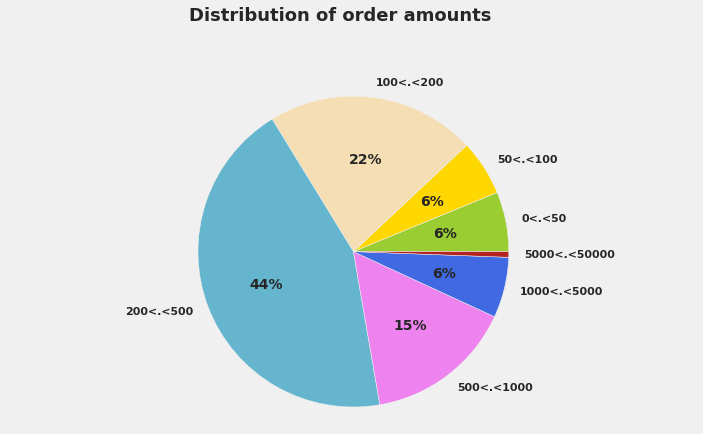

In [ ]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i,price in enumerate(price_range):
    if i==0:continue
    val = basket_price[(basket_price['Basket Price'] < price)&
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()

It can be seen that majority of orders concern relatively large purchases given that  ∼ 65% of purchases give prices in excess of £ 200.



# Product Categories

From what I have noticed, products are identified by their 'Stockcode' and some description is given of it under the 'Description' column. So now, from the content in 'Description', I'm going to group the products into different categories.

Here's where I'm going to extract content from the 'Description' variable by using nltk.

In [ ]:
is_noun = lambda pos:pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    import nltk
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()
    keywords_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
        
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            
            category_keys.append(clef)
            keywords_select[s] = clef
        
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("Number of keywords in the variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

So, what is done here is, the names (proper, common) appearing in the products description are extracted.
for each name, I extracted the root of the word and aggregated the set of names associated with this particular root.
Counted the number of times each root appears in the dataframe.
when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

In [ ]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:"Description"})

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [ ]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Number of keywords in the variable 'Description': 1483


The execution of this function returns three variables:

keywords: the list of extracted keywords

keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots

count_keywords: dictionary listing the number of times every word is used

I converted the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [ ]:
# Plotting keywords vs frequency graph :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    list_products.append([word, v])

Now, I have made a plot of the most common keywords and its occurences.

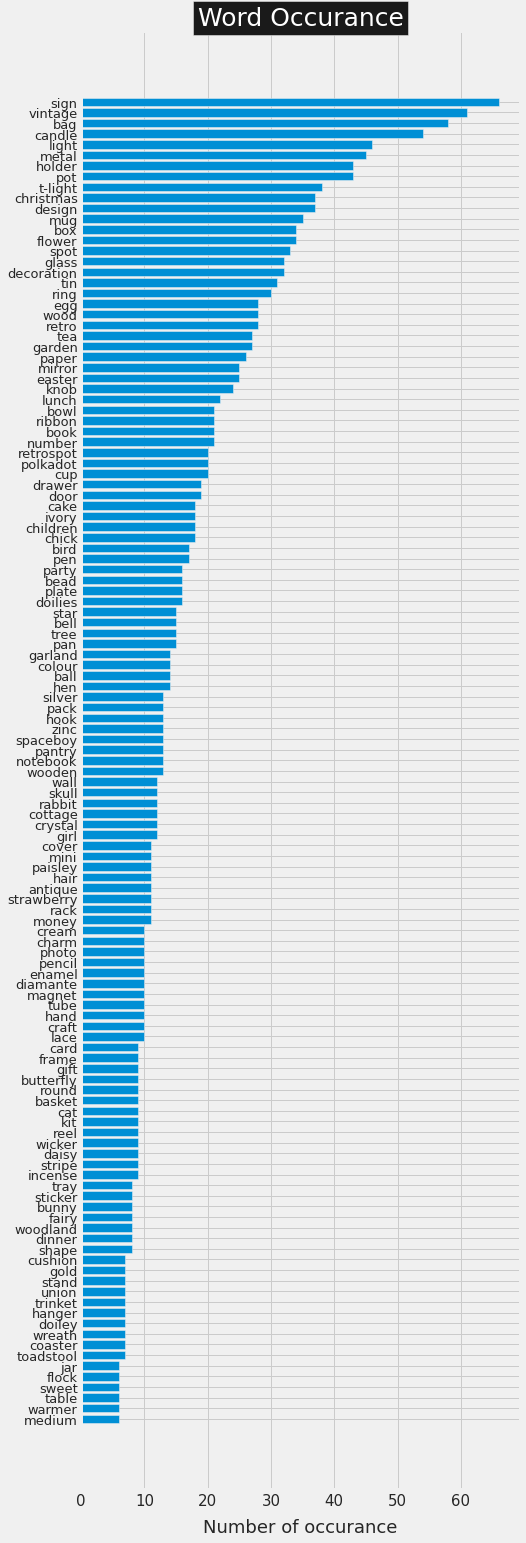

In [ ]:
lista = sorted(list_products, key = lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurance", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Word Occurance", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

Defining Product category: The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, some names seem to be useless, like colors which don't carry any information. Therefore, I discard these words and I decided to consider only the words that appear more than 13 times.

In [ ]:
# Preserving important words :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word)<3 or v<13: continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse=True)
print("Number of preserved words : ", len(list_products))

Number of preserved words :  193


Now I will use these keywords to create groups of product. Firstly, I define the  X  matrix as: where the  ai,j  coefficient is 1 if the description of the product  i  contains the word  j , and 0 otherwise.

The  X  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. Introducing the price range might result in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [ ]:
t = [0, 1, 2, 3, 5, 10]

# Getting the description.
liste_produits = df_cleaned['Description'].unique()

# Creating the product and word matrix.
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
    

label_col = []
for i in range(len(t)):
    if i == len(t) - 1:
        col = '.>{}'.format(t[i])
    else:
        col = '{}<.<{}'.format(t[i], t[i+1])
        
    label_col.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    
    while prix > t[j]:
        j += 1
        if j == len(t):
            break
    X.loc[i, label_col[j-1]] = 1

To choose the appropriate ranges, I check the number of products in the different groups:

In [ ]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(t)):
    if i == len(t)-1:
        col = '.>{}'.format(t[i])
    else:
        col = '{}<.<{}'.format(t[i],t[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


# **K Means Clustering**

Now,  I will group the products into different classes. For this I'm using the K means clustering method.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
matrix = X.values

In [ ]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.09687971860732911
For n_clusters :  4 The average silhouette_score is :  0.1268004588393788
For n_clusters :  5 The average silhouette_score is :  0.1300062476994955
For n_clusters :  6 The average silhouette_score is :  0.1468417720707063
For n_clusters :  7 The average silhouette_score is :  0.14779720510063515
For n_clusters :  8 The average silhouette_score is :  0.1374935597424496
For n_clusters :  9 The average silhouette_score is :  0.11673001441456807


For the first cluster, we obtain a slightly lower score. I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate until the best possible silhouette score is obtained, which is, in the present case, around 0.14:

In [ ]:
# Choosing number of clusters as 5:
# Trying Improving the silhouette_score :
n_clusters = 5
sil_avg = -1
while sil_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  5 The average silhouette_score is :  0.14679607861398997


Characterizing the content of clusters: check the number of elements in every class:

In [ ]:
# Printing number of elements in each cluster :
pd.Series(clusters).value_counts()

1    1009
4     964
0     829
3     606
2     470
dtype: int64

Representing the silhouette scores of each element of the different clusters.

In [ ]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    import matplotlib as mpl
    mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhoutte_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhoutte_values.sort()
        size_cluster_i = ith_cluster_silhoutte_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhoutte_values, alpha = 0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                 bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle = 'round, pad = 0.3'))
        
        y_lower = y_upper + 10

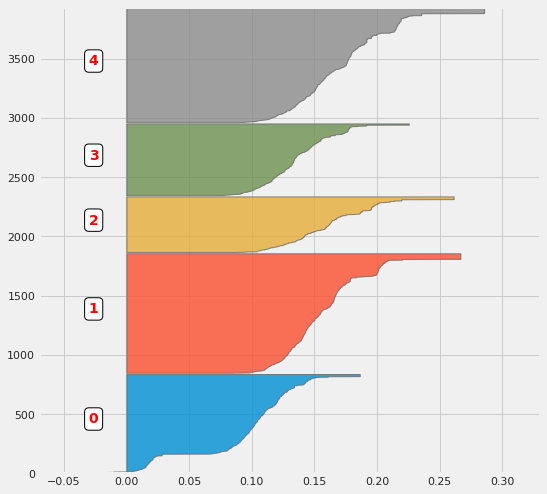

In [ ]:
# Plotting the intra cluster silhouette distances.
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

Looking at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [ ]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurance) in list_products]

occurance = [dict() for _ in range(n_clusters)]

In [ ]:
# Creating data for printing word cloud.
for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurance[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [ ]:
# Code for printing word cloud.
from random import randint
import random
def random_color_func(word=None, font_size=None, position=None,orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [ ]:
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurances = liste[0:150]
    for s in trunc_occurances:
        words[s[0]] = s[1]
        
    wc = wordcloud.WordCloud(width=1000,height=400, background_color='lightgrey', max_words=1628,relative_scaling=1,
                             color_func = random_color_func, normalize_plurals=False)
    wc.generate_from_frequencies(words)
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

Printing the word cloud

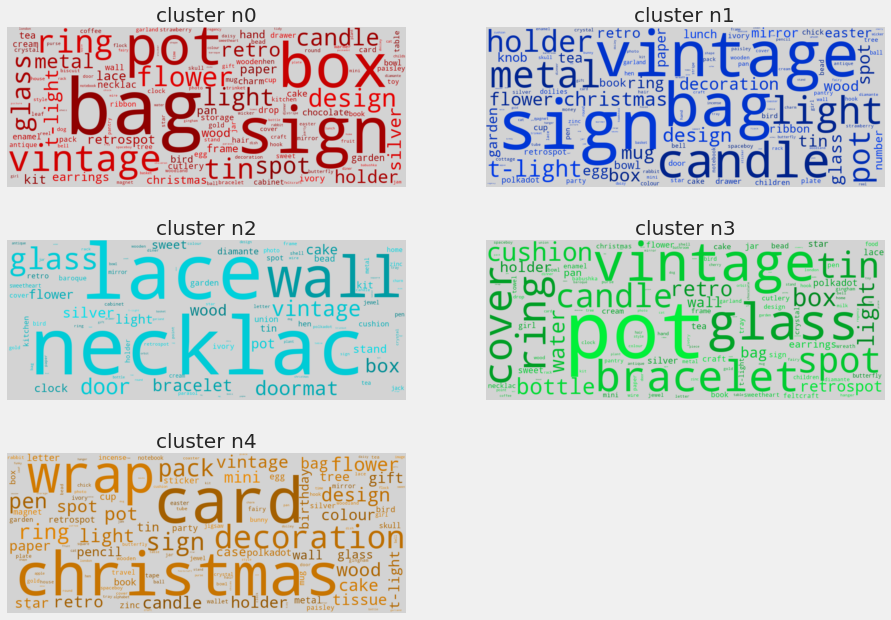

In [ ]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurance[i]
    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

If we closely look at cluster n4, we can see that it contains words related to gifts and it can be seen in cluster n1 that some accessories and luxury items are present. Anyways, the clustering seems ambiguous because many words are present.

# Principle Component Analysis

In order to get a clear distinction of these clusters, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

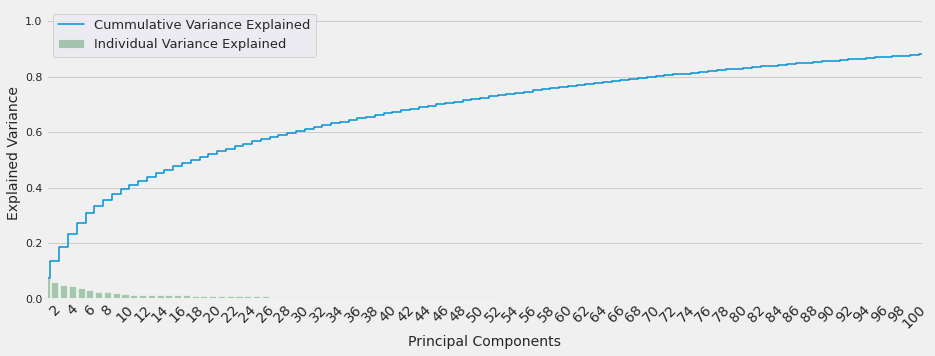

In [ ]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 100)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. So I decided to keep only a limited number of components since this decomposition is only performed to visualize the data. 

In [ ]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

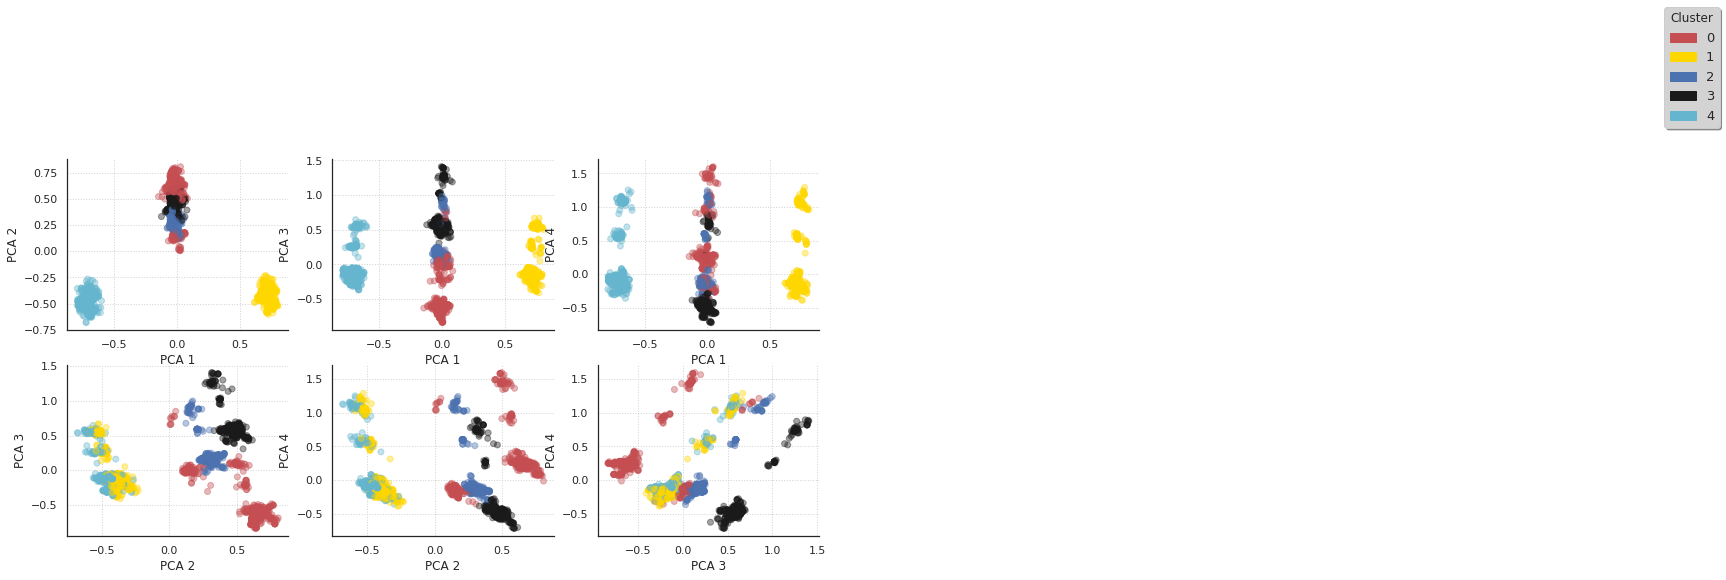

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        

comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(2, 1.1), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

# **Customer Categories**

In the previous section, the different products were grouped in five clusters.To go ahead with categorizing customers I create the categorical variable categ_product where I indicate the cluster of each product:

In [ ]:
corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val
    
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0
1,536365,WHITE METAL LANTERN,3
2,536365,CREAM CUPID HEARTS COAT HANGER,3
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,3
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3
5,536365,SET 7 BABUSHKA NESTING BOXES,2
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,3
7,536366,HAND WARMER UNION JACK,0
8,536366,HAND WARMER RED POLKA DOT,1
9,536367,ASSORTED COLOUR BIRD ORNAMENT,1


I created the 'categ_N' variables (with  N∈ [0:4] ) that contains the amount spent in each product category:

In [ ]:
# Creating 5 new features that will contain the amount in a single transanction on different categories of product.
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.00,0.0,0.00,0.0
1,536365,WHITE METAL LANTERN,3,0.0,0.00,0.0,20.34,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,3,0.0,0.00,0.0,22.00,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,3,0.0,0.00,0.0,20.34,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.0,0.00,0.0,20.34,0.0
5,536365,SET 7 BABUSHKA NESTING BOXES,2,0.0,0.00,15.3,0.00,0.0
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,3,0.0,0.00,0.0,25.50,0.0
7,536366,HAND WARMER UNION JACK,0,11.1,0.00,0.0,0.00,0.0
8,536366,HAND WARMER RED POLKA DOT,1,0.0,11.10,0.0,0.00,0.0
9,536367,ASSORTED COLOUR BIRD ORNAMENT,1,0.0,54.08,0.0,0.00,0.0


So, the information related to a single order was split over several lines of the dataframe (one line per product). Now, I'm going to collect the information related to a particular order and put in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [ ]:
# sum of purchases by user and order.
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

# percentage spent on each product category 
for i in range(5):
    col = "categ_{}".format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp

# Dates of the order.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# Selecting entries with basket price > 0.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347.0,537626,711.79,83.40,187.2,124.44,293.35,23.40,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,91.35,130.5,0.00,169.20,84.34,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,109.35,330.9,0.00,115.00,81.00,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,78.06,74.4,19.90,168.76,41.40,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,157.95,109.7,97.80,158.16,61.30,2011-08-02 08:48:00.000000000


The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [ ]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [ ]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.datetime(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.datetime(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

Here, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [ ]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,18.636191,29.836681,8.676179,32.408290,10.442659
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,0.000000,0.000000,38.016069
2,12350.0,1,334.40,334.40,334.400000,334.40,39.862440,48.444976,0.000000,0.000000,11.692584
3,12352.0,6,144.35,840.30,345.663333,2073.98,56.603728,12.892120,14.301006,15.711338,0.491808
4,12353.0,1,89.00,89.00,89.000000,89.00,64.606742,13.033708,22.359551,0.000000,0.000000


Now, I define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [ ]:
# Generating two new variables - days since first puchase and days since last purchase.
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transanctions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

In [ ]:
transanctions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,18.636191,29.836681,8.676179,32.408290,10.442659,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,0.000000,0.000000,38.016069,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,39.862440,48.444976,0.000000,0.000000,11.692584,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,56.603728,12.892120,14.301006,15.711338,0.491808,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,64.606742,13.033708,22.359551,0.000000,0.000000,134,134


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [ ]:
n1 = transanctions_per_user[transanctions_per_user['count'] == 1].shape[0]
n2 = transanctions_per_user.shape[0]
print("No. of Customers with single purchase : {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1/n2*100))

No. of Customers with single purchase : 1445/3608  (40.05%)


Creating customer categories: The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [ ]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transanctions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].to_numpy()

Standardizing the data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print("Variable Mean Values: \n" + 90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Variable Mean Values: 
------------------------------------------------------------------------------------------
 [  3.62 259.93 556.27 377.06  28.74  25.23  15.68  16.37  13.99]


I will now create clusters of customers. Before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the scaled_matrix matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [ ]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

Representing the amount of variance explained by each of the components:

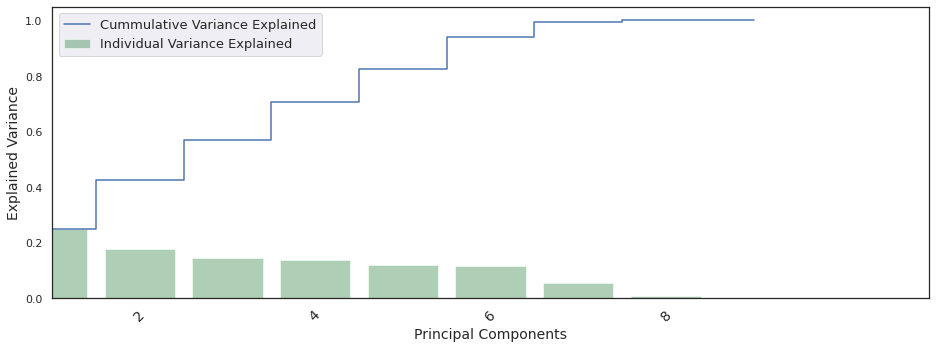

In [ ]:
## Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 10)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

 I define clusters of clients from the standardized matrix that was defined earlier and using the k-means algorithm fromscikit-learn. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 10 clusters:

In [ ]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 21):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.15103281302353322
For n_clusters :  4 The average silhouette_score is :  0.16354250082853902
For n_clusters :  5 The average silhouette_score is :  0.17224856619573747
For n_clusters :  6 The average silhouette_score is :  0.17409326936298486
For n_clusters :  7 The average silhouette_score is :  0.18906003196886553
For n_clusters :  8 The average silhouette_score is :  0.20164687134204284
For n_clusters :  9 The average silhouette_score is :  0.20219123020982194
For n_clusters :  10 The average silhouette_score is :  0.20929418851267811
For n_clusters :  11 The average silhouette_score is :  0.1916219223533211
For n_clusters :  12 The average silhouette_score is :  0.19726342601637273
For n_clusters :  13 The average silhouette_score is :  0.1874998295217254
For n_clusters :  14 The average silhouette_score is :  0.1951284266240276
For n_clusters :  15 The average silhouette_score is :  0.18573174891004868
For n_clusters :  16 T

In [ ]:
# Choosing number of clusters as 10:
# Trying Improving the silhouette_score :
n_clusters = 10
sil_avg = -1
while sil_avg < 0.208:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  10 The average silhouette_score is :  0.21117221975372108


In [ ]:
n_clusters = 10
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("Silhouette Score : {:<.3f}".format(silhouette_avg))

Silhouette Score : 0.209


looking at the number of customers in each cluster:

In [ ]:
# Looking at clusters :
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns=['Number of Clients']).T

,4,0,3,5,7,1,2,9,8,6
Number of Clients,1502,508,443,360,301,243,207,21,12,11


To look at the quality of the separation, I have plotted silouhette scores within different clusters:

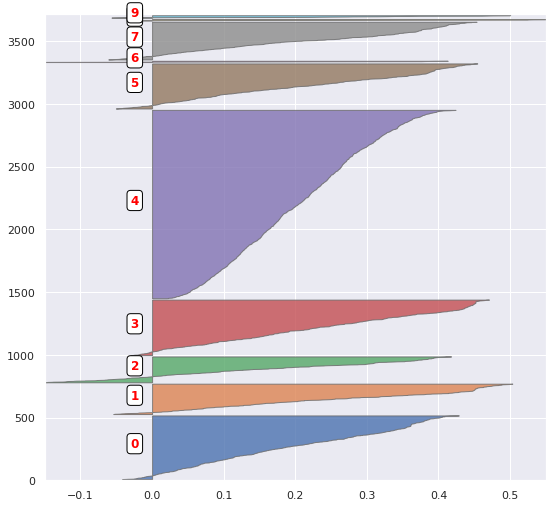

In [ ]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

To understand the habits of the customers in each cluster, I added to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable size ):

In [ ]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
    
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers : ', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

Number of customers :  3608


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount spent in each product category and then, according to the total amount spent:

In [ ]:
# Reorganizing the content of the dataframe.
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
    
liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df.head()

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
0,3.0,2.546275,206.818849,358.329007,275.356012,779.124944,64.981925,11.936042,9.945658,7.331384,5.804991,115.934537,192.814898,443
1,0.0,2.405512,219.554705,332.677207,272.868949,689.679943,17.024988,55.656389,5.808678,8.136823,13.376052,103.826772,174.374016,508
2,5.0,2.669444,193.563475,319.247361,249.105992,707.273447,18.339652,11.443919,51.711695,13.233769,5.286640,119.338889,192.219444,360
3,7.0,2.146179,205.331229,357.319269,269.240759,694.776844,17.997820,13.642041,10.957708,50.790760,6.663130,110.023256,169.176080,301
4,1.0,2.172840,193.523457,314.790576,246.074309,571.561399,13.445938,18.217557,5.540580,6.338049,56.457876,98.316872,165.827160,243


Creating csv files of selected customers and of the categorized customers

In [ ]:
selected_customers.to_csv("selected_customers.csv")

In [ ]:
merged_df.to_csv("merged_df.csv")

In [ ]:
selected_customers = pd.read_csv('selected_customers.csv')
merged_df = pd.read_csv('merged_df.csv')

# **Classification of customers**

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
class Class_Fit(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} %".format(100 * accuracy_score(Y, self.predictions)))

In [ ]:
selected_customers.head()

,Unnamed: 0,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,0,12347.0,5,382.52,711.79,558.172000,2790.86,18.636191,29.836681,8.676179,32.408290,10.442659,59,297,4
1,1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,41.953217,0.000000,0.000000,38.016069,5,288,0
2,2,12350.0,1,334.40,334.40,334.400000,334.40,39.862440,48.444976,0.000000,0.000000,11.692584,240,240,0
3,3,12352.0,6,144.35,840.30,345.663333,2073.98,56.603728,12.892120,14.301006,15.711338,0.491808,2,226,3
4,4,12353.0,1,89.00,89.00,89.000000,89.00,64.606742,13.033708,22.359551,0.000000,0.000000,134,134,3


I'm only keeping the variables that describe the content of the basket, and not taking into account the variables related to the frequency of visits or variations of the basket price over time:

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

Splitting the dataset into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

In [ ]:
from sklearn.linear_model import LogisticRegression


# Logistic Regression

In [ ]:
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-1,2,10)}], Kfold = 5)
lr.grid_fit(X_train, Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 94.04 %


Confusion Matrix: The accuracy of the results seems to be correct. But, it can be noted that when the different classes were defined, there was an imbalance in size between the classes obtained. It is therefore interesting to look at how the predictions and real values compare to the rest of the different classes

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[102   1   0   0   3   0   0   0   0   0]
 [  0  49   1   0   2   1   0   0   0   0]
 [  1   0  27   1   3   0   0   0   0   0]
 [  1   0   0  74   6   1   0   0   0   0]
 [  3   2   2   3 303   0   0   1   0   0]
 [  0   0   0   0   1  67   0   0   0   0]
 [  0   0   1   0   0   0   0   0   2   0]
 [  0   0   0   0   2   0   0  56   0   0]
 [  0   0   0   0   0   0   0   0   1   0]
 [  0   0   1   0   3   0   0   1   0   0]]


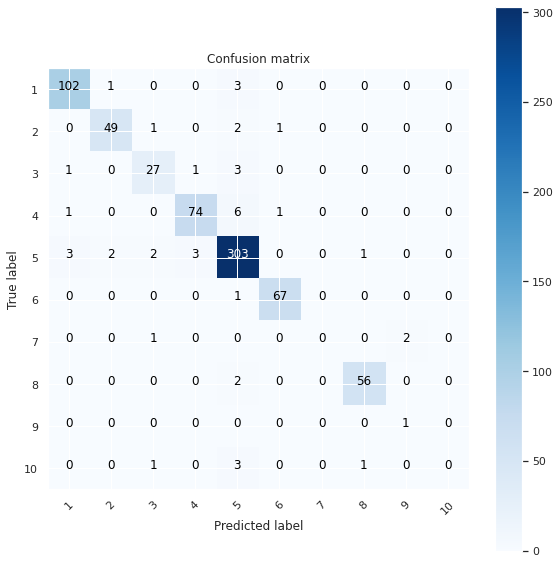

In [ ]:
class_names = [i for i in range(1,11)]
cnf = confusion_matrix(Y_test, lr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

Learning Curve: A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. So, I plot a Learning curve for all the classification methods.

In [ ]:

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

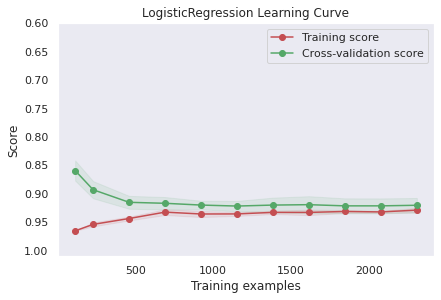

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, "LogisticRegression Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# **Support Vector Machine Classifier**

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svc = Class_Fit(clf=LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [ ]:
svc.grid_fit(X=X_train, Y=Y_train)

In [ ]:
svc.grid_predict(X_test, Y_test)

Precision: 83.93 %


Confusion matrix, without normalization
[[ 80   0   0   0  26   0   0   0   0   0]
 [  0  42   0   0  10   1   0   0   0   0]
 [  1   0   0   0  29   0   0   2   0   0]
 [  0   0   0  62  20   0   0   0   0   0]
 [  0   0   0   0 312   0   0   2   0   0]
 [  0   0   0   0  13  55   0   0   0   0]
 [  0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0   3   0   0  55   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   4   0   0   1   0   0]]


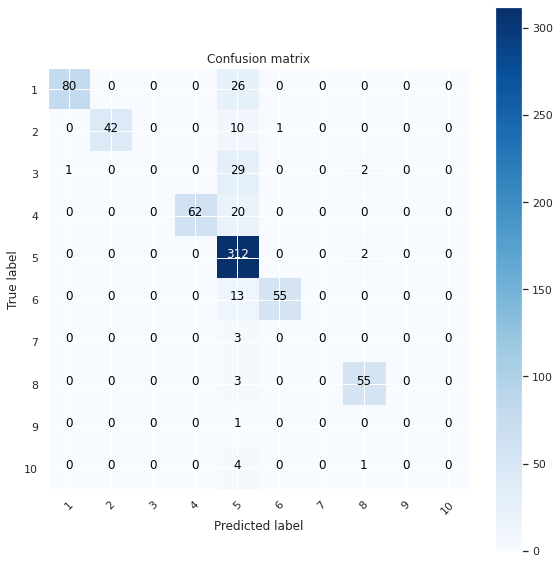

In [ ]:
class_names = [i for i in range(1,11)]
cnf = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

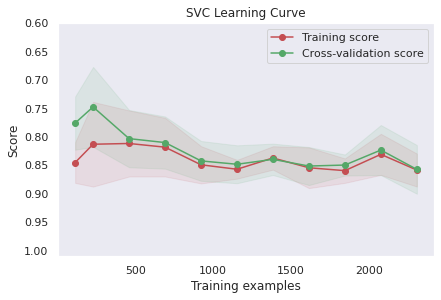

In [ ]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# **K Nearest Neighbours Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = Class_Fit(clf = KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X_train, Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 83.10 %


Confusion matrix, without normalization
[[ 84   1   2   0  19   0   0   0   0   0]
 [  1  42   1   1   8   0   0   0   0   0]
 [  0   0  26   0   6   0   0   0   0   0]
 [  0   0   1  62  18   1   0   0   0   0]
 [  8   0   5   6 293   2   0   0   0   0]
 [  1   0   1   1  13  52   0   0   0   0]
 [  0   0   1   0   0   0   2   0   0   0]
 [  0   0   0   0  19   0   0  39   0   0]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   0   1   0   3   0   0   1   0   0]]


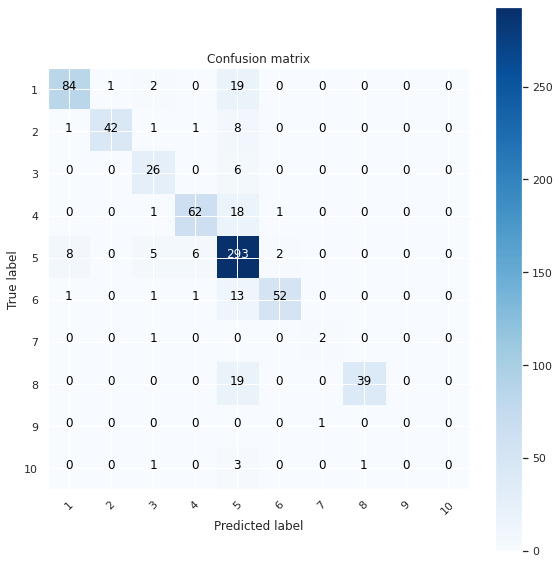

In [ ]:
cnf = confusion_matrix(Y_test, knn.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

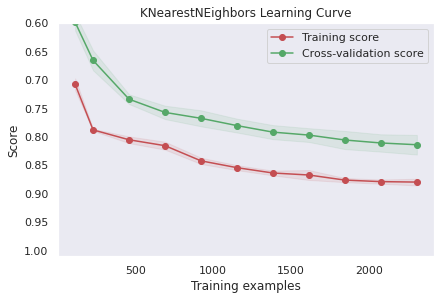

In [ ]:
g = plot_learning_curve(knn.grid.best_estimator_, "KNearestNEighbors Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# **Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tr = Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X_train, Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 88.37 %


Confusion matrix, without normalization
[[ 97   1   2   0   5   1   0   0   0   0]
 [  2  45   0   0   3   3   0   0   0   0]
 [  0   0  20   0   7   0   0   1   0   4]
 [  0   0   1  72   8   1   0   0   0   0]
 [ 10   3   7   4 282   2   0   3   0   3]
 [  0   0   0   0   2  66   0   0   0   0]
 [  0   0   2   0   0   0   0   0   1   0]
 [  0   1   0   0   1   0   0  55   0   1]
 [  0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   4   0   0   1   0   0]]


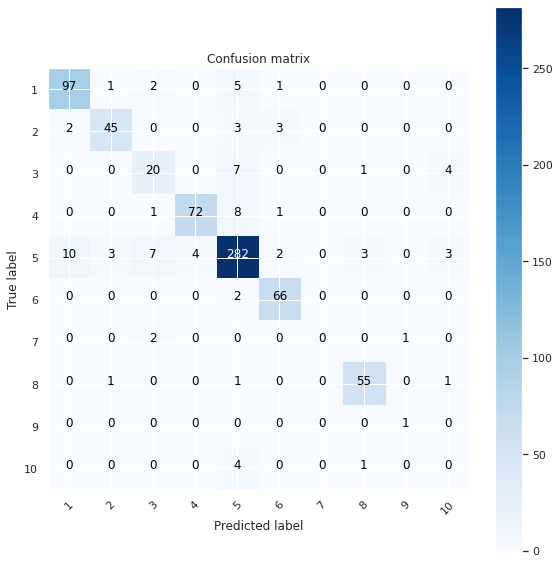

In [ ]:
cnf = confusion_matrix(Y_test, tr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

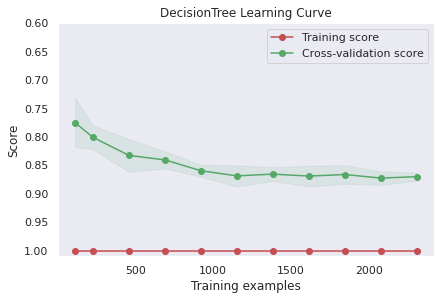

In [ ]:
g = plot_learning_curve(tr.grid.best_estimator_, "DecisionTree Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = Class_Fit(clf = RandomForestClassifier)
rf.grid_search(parameters = [{'criterion':['entropy', 'gini'], 
                              'max_features':['sqrt', 'log2'], 'n_estimators':[20, 40, 60, 80, 100]}], Kfold = 5)
rf.grid_fit(X_train, Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 92.24 %


Confusion matrix, without normalization
[[ 98   0   2   0   6   0   0   0   0   0]
 [  1  48   0   1   0   3   0   0   0   0]
 [  1   0  22   1   5   0   0   3   0   0]
 [  1   0   0  77   4   0   0   0   0   0]
 [  5   1   5   5 296   1   0   1   0   0]
 [  0   0   0   0   1  67   0   0   0   0]
 [  0   0   3   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0  57   0   0]
 [  0   0   0   0   0   0   0   0   1   0]
 [  0   0   1   0   3   0   0   1   0   0]]


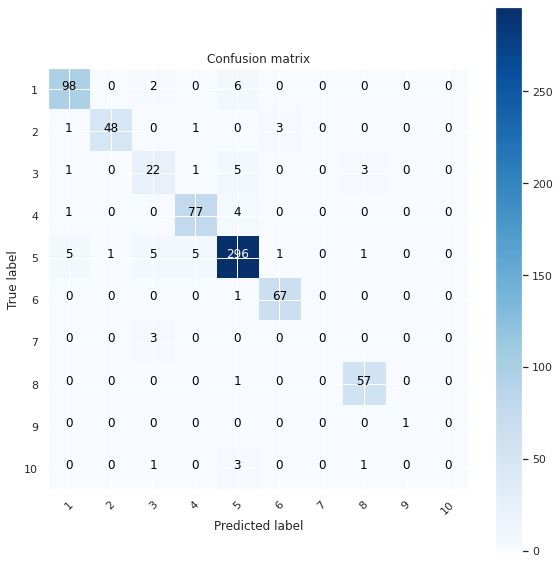

In [ ]:
cnf = confusion_matrix(Y_test, rf.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

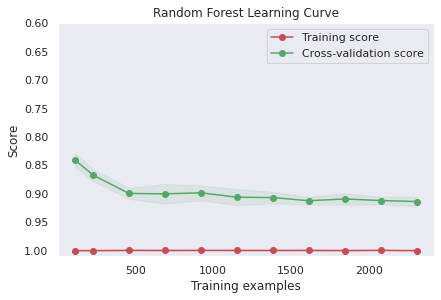

In [ ]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the VotingClassifier method of the sklearn package. As a first step, I adjust the parameters of the various classifiers using the best parameters previously found:

In [ ]:
rf_best = RandomForestClassifier(**rf.grid.best_params_)
svc_best = LinearSVC(**svc.grid.best_params_)
tr_best = DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = KNeighborsClassifier(**knn.grid.best_params_)
lr_best = LogisticRegression(**lr.grid.best_params_)

In [ ]:
from sklearn.ensemble import VotingClassifier

Then, I define a classifier that merges the results of the various classifiers

In [ ]:
votingC = VotingClassifier(estimators=[('rf', rf_best), ('svc',svc_best), ('tr',tr_best),('knn', knn_best), ('lr', lr_best)])

And Training it:

In [ ]:
votingC = votingC.fit(X_train, Y_train)

In [ ]:
predictions = votingC.predict(X_test)

Finally, we can create a prediction for this model:

In [ ]:
print("Precision : {:.2f}%".format(100 * accuracy_score(Y_test, predictions)))

Precision : 93.35%


# **Testing Predictions**

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model the last two months of the dataset, that has been stored in the set_test dataframe:

In [ ]:
basket_price = set_test.copy(deep = True)

Here I'm regrouping the data according to the format of the data used in the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables count and sum to obtain an equivalence with the training set:

In [ ]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

transanctions_per_user['count'] = 5 * transanctions_per_user['count']
transanctions_per_user['sum'] = transanctions_per_user['count'] * transanctions_per_user['mean']

transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,10,224.82,1294.32,759.57,7595.70,37.379043,20.017905,5.634767,24.271627,12.696657
1,12349.0,5,1757.55,1757.55,1757.55,8787.75,37.877728,26.506216,20.389178,10.713778,4.513101
2,12352.0,5,311.73,311.73,311.73,1558.65,34.398358,34.420813,17.290604,7.217785,6.672441
3,12356.0,5,58.35,58.35,58.35,291.75,100.000000,0.000000,0.000000,0.000000,0.000000
4,12357.0,5,6207.67,6207.67,6207.67,31038.35,22.895547,18.475531,25.189000,28.350089,5.089832


Converting the dataframe into a matrix and retaining only variables that define the category to which consumers belong. Also, normalizing the data.

In [ ]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
matrix_test = transanctions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits.

In [ ]:
Y = kmeans.predict(scaled_test_matrix)


In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transanctions_per_user[columns]


In [ ]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest')]

for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 82.09 %
______________________________ 
Logostic Regression
Precision: 88.48 %
______________________________ 
k-Nearest Neighbors
Precision: 81.46 %
______________________________ 
Decision Tree
Precision: 83.14 %
______________________________ 
Random Forest
Precision: 86.83 %


In [ ]:
predictions = votingC.predict(X)
print("Precision : {:.2f}%".format(100 * accuracy_score(Y, predictions)))

Precision : 87.61%
